# SETUP: KONFIGURASI PROYEK

In [19]:
import pandas as pd
import ast  # Untuk mengubah string dictionary menjadi dictionary
import matplotlib.pyplot as plt
import seaborn as sns # Library untuk visualisasi yang lebih baik
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

# --- KONFIGURASI PROYEK ---
NAMA_FILE = 'SEntFiN-v1.1.csv'
RANDOM_STATE = 42
MAX_LENGTH = None

# TAHAP 1: EKSPLORASI DATA

Berhasil memuat SEntFiN-v1.1.csv (10753 baris).

--- 1.0: Data Teratas (Head) ---
   S No.                                              Title  \
0      1  SpiceJet to issue 6.4 crore warrants to promoters   
1      2                  MMTC Q2 net loss at Rs 10.4 crore   
2      3  Mid-cap funds can deliver more, stay put: Experts   
3      4             Mid caps now turn into market darlings   
4      5  Market seeing patience, if not conviction: Pra...   

                       Decisions  Words  
0        {"SpiceJet": "neutral"}      8  
1            {"MMTC": "neutral"}      8  
2  {"Mid-cap funds": "positive"}      8  
3       {"Mid caps": "positive"}      7  
4          {"Market": "neutral"}      8  


--- 1.0: Tipe Data Kolom (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10753 entries, 0 to 10752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S No.      10753 non-null  int64 
 1   Title      10753 no

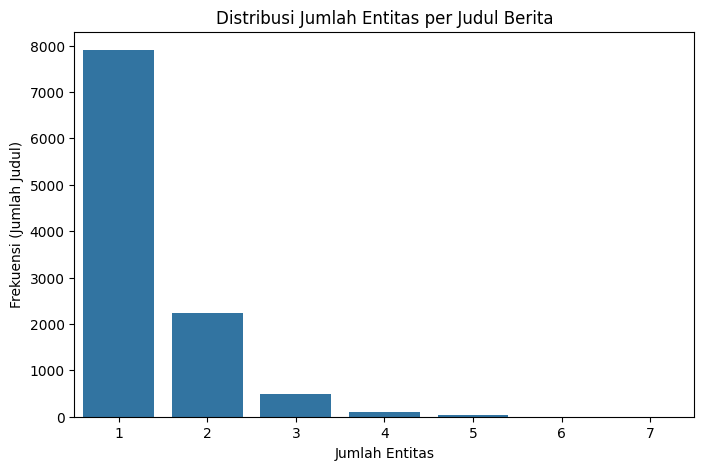

KESIMPULAN:
1. Rata-rata 1.34 entitas per berita.
2. Maksimum 7 entitas dalam 1 berita.

--- 1.2: Analisis Distribusi Label ---
Total label setelah di-flatten: 14409
Distribusi:
Counter({'neutral': 5515, 'positive': 5075, 'negative': 3819})


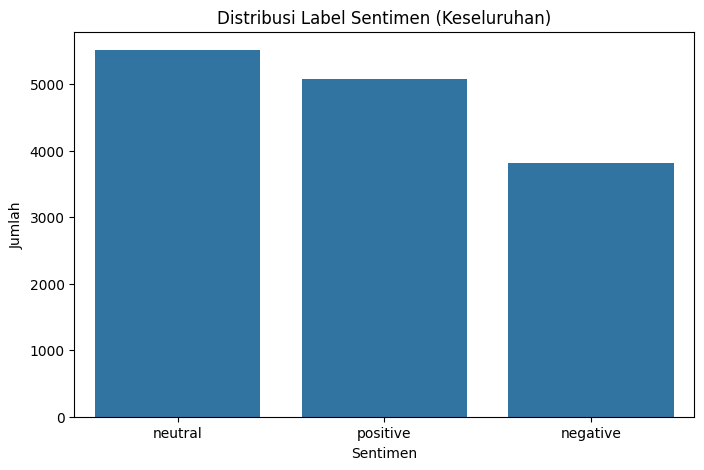


--- 1.3: Analisis Entitas Teratas ---
Entitas paling sering muncul (Top 10):
[('Nifty', 421), ('Sebi', 320), ('Sensex', 281), ('Infosys', 131), ('Gold', 123), ('BSE', 106), ('Rupee', 92), ('RBI', 88), ('rupee', 84), ('gold', 83)]


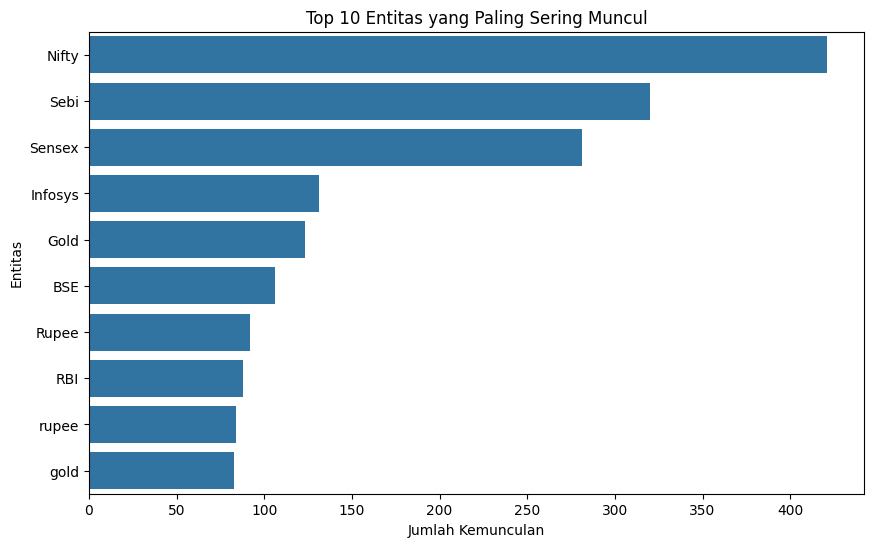


--- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---
Memuat tokenizer RoBERTa untuk menghitung panjang token...

Statistik Panjang Token:
count    10686.000000
mean        16.593393
std          4.215957
min          7.000000
50%         16.000000
95%         24.000000
99%         28.000000
max         39.000000
dtype: float64

Panjang token MAKSIMUM aktual di dataset: 39
Panjang token 99% data: 28


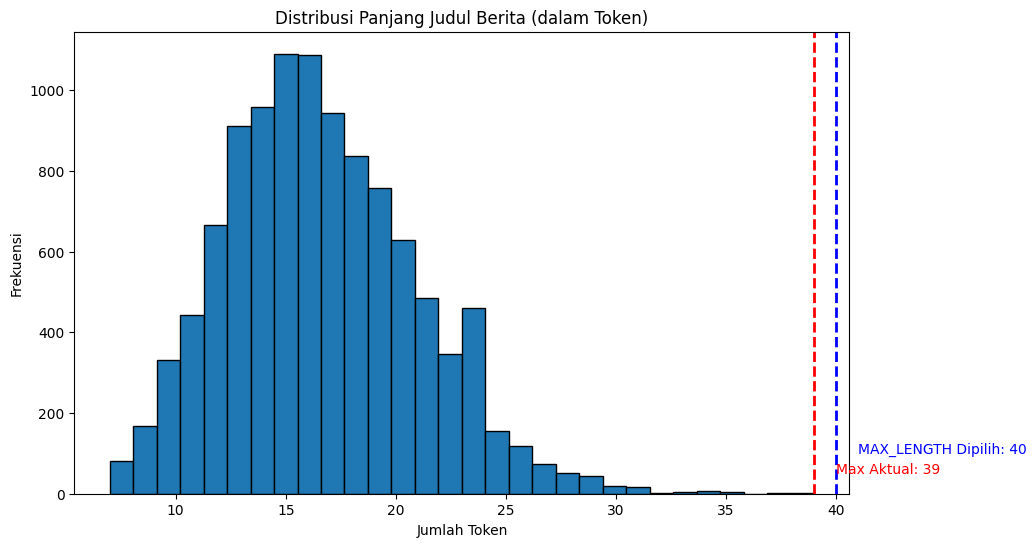

KESIMPULAN: MAX_LENGTH ditetapkan ke 40.


In [26]:
try:
  df = pd.read_csv(NAMA_FILE)
  print(f"Berhasil memuat {NAMA_FILE} ({len(df)} baris).\n")

  # --- 1.0: Melihat Data Mentah ---
  print("--- 1.0: Data Teratas (Head) ---")
  print(df.head())
  print("\n")

  print("--- 1.0: Tipe Data Kolom (Info) ---")
  df.info()
  print("Parsing kolom 'Decisions' (string -> dictionary)...")
  print("\n")

  try:
      df['Decisions_dict'] = df['Decisions'].apply(ast.literal_eval)
  except Exception as e:
      print(f"Error: Gagal parsing kolom 'Decisions'. Error: {e}")
      exit()

  # --- 1.1: Analisis Distribusi Jumlah Entitas per Berita ---
  print("--- 1.1: Analisis Jumlah Entitas per Berita ---")
  df['num_entities'] = df['Decisions_dict'].apply(len)

  print(df['num_entities'].describe())

  plt.figure(figsize=(8, 5))
  sns.countplot(x=df['num_entities'])
  plt.title('Distribusi Jumlah Entitas per Judul Berita')
  plt.xlabel('Jumlah Entitas')
  plt.ylabel('Frekuensi (Jumlah Judul)')
  plt.show()

  print(f"KESIMPULAN:\n1. Rata-rata {df['num_entities'].mean():.2f} entitas per berita.")
  print(f"2. Maksimum {df['num_entities'].max()} entitas dalam 1 berita.")

  # --- 1.2: Analisis Distribusi Label Sentimen ---
  print("\n--- 1.2: Analisis Distribusi Label ---")
  all_labels = [label for decisions in df['Decisions_dict'] for label in decisions.values()]
  label_counts = Counter(all_labels)

  print(f"Total label setelah di-flatten: {len(all_labels)}")
  print(f"Distribusi:\n{label_counts}")

  # Cek class imbalance
  if label_counts['neutral'] > (label_counts['positive'] + label_counts['negative']):
      print("KESIMPULAN: Data 'imbalanced'. Kita perlu 'Weighted Loss' & 'Macro F1'.")

  df_labels = pd.DataFrame(label_counts.items(), columns=['Label', 'Jumlah'])
  plt.figure(figsize=(8, 5))
  sns.barplot(data=df_labels, x='Label', y='Jumlah')
  plt.title('Distribusi Label Sentimen (Keseluruhan)')
  plt.xlabel('Sentimen')
  plt.ylabel('Jumlah')
  plt.show()

  # --- 1.3: Analisis Entitas Teratas ---
  print("\n--- 1.3: Analisis Entitas Teratas ---")
  all_entities = [entity for decisions in df['Decisions_dict'] for entity in decisions.keys()]
  entity_counts = Counter(all_entities)
  print("Entitas paling sering muncul (Top 10):")
  print(entity_counts.most_common(10))

  df_entities = pd.DataFrame(entity_counts.most_common(10), columns=['Entitas', 'Jumlah'])
  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_entities, y='Entitas', x='Jumlah', orient='h')
  plt.title('Top 10 Entitas yang Paling Sering Muncul')
  plt.xlabel('Jumlah Kemunculan')
  plt.ylabel('Entitas')
  plt.show()

  # --- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---
  print("\n--- 1.4: Analisis Panjang Teks (Mencari MAX_LENGTH) ---")
  print("Memuat tokenizer RoBERTa untuk menghitung panjang token...")
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

  unique_titles = df['Title'].unique()
  token_lengths = [len(tokenizer.encode(title)) for title in unique_titles]
  lengths_series = pd.Series(token_lengths)

  print("\nStatistik Panjang Token:")
  print(lengths_series.describe(percentiles=[0.95, 0.99]))

  plt.figure(figsize=(10, 6))
  plt.hist(lengths_series, bins=30, edgecolor='k')
  plt.title('Distribusi Panjang Judul Berita (dalam Token)')
  plt.xlabel('Jumlah Token')
  plt.ylabel('Frekuensi')

  # --- PENENTUAN MAX_LENGTH SECARA OTOMATIS ---
  max_actual = lengths_series.max()
  persentil_99 = int(lengths_series.quantile(0.99))

  print(f"\nPanjang token MAKSIMUM aktual di dataset: {max_actual}")
  print(f"Panjang token 99% data: {persentil_99}")

  # MAX_LENGTH: max aktual dan bulatkan ke kelipatan 8 terdekat
  if max_actual % 8 == 0:
    MAX_LENGTH = max_actual
  else:
    MAX_LENGTH = max_actual + (8 - max_actual % 8)

  plt.axvline(max_actual, color='red', linestyle='dashed', linewidth=2)
  plt.text(max_actual + 1, 50, f'Max Aktual: {max_actual}', color='red')
  plt.axvline(MAX_LENGTH, color='blue', linestyle='dashed', linewidth=2)
  plt.text(MAX_LENGTH + 1, 100, f'MAX_LENGTH Dipilih: {MAX_LENGTH}', color='blue')
  plt.show()

  print(f"KESIMPULAN: MAX_LENGTH ditetapkan ke {MAX_LENGTH}.")

except FileNotFoundError:
  print(f"ERROR: File '{NAMA_FILE}' tidak ditemukan.")
  exit()

# TAHAP 2: DATA SPLITTING

In [8]:
print("Melakukan split data 80/20 berdasarkan 'Judul Unik' (Anti-Leakage)...")

unique_titles = df['Title'].unique()
train_titles, test_titles = train_test_split(
  unique_titles,
  test_size=0.2,
  random_state=RANDOM_STATE
)
train_df = df[df['Title'].isin(train_titles)]
test_df = df[df['Title'].isin(test_titles)]

print(f"Judul unik untuk latih: {len(train_titles)}")
print(f"Judul unik untuk uji: {len(test_titles)}")

Melakukan split data 80/20 berdasarkan 'Judul Unik' (Anti-Leakage)...
Judul unik untuk latih: 8548
Judul unik untuk uji: 2138


# TAHAP 3: FLATTENING

In [15]:
def flatten_dataset(dataframe):
    flattened_data = []
    for _, row in dataframe.iterrows():
        sentence = row['Title']
        decisions = row['Decisions_dict']
        for entity, label in decisions.items():
            flattened_data.append({
                'entity': entity,
                'sentence': sentence,
                'label': label
            })
    return pd.DataFrame(flattened_data)

train_flat = flatten_dataset(train_df)
test_flat = flatten_dataset(test_df)

print(f"Data latih (flat) dibuat: {len(train_flat)} baris")
print(f"Data uji (flat) dibuat: {len(test_flat)} baris")
print("\nContoh data latih yang sudah di-flatten:")
print(train_flat.head())

Data latih (flat) dibuat: 11493 baris
Data uji (flat) dibuat: 2916 baris

Contoh data latih yang sudah di-flatten:
          entity                                           sentence     label
0           MMTC                  MMTC Q2 net loss at Rs 10.4 crore   neutral
1  Mid-cap funds  Mid-cap funds can deliver more, stay put: Experts  positive
2         Market  Market seeing patience, if not conviction: Pra...   neutral
3        Infosys    Infosys: Will the strong volume growth sustain?   neutral
4          Hudco          Hudco raises Rs 279 cr via tax-free bonds  positive


# TAHAP 4: PREPROCESSING

In [27]:
# --- 4.1: Label Encoding ---
print("\n--- 4.1: Label Encoding ---")
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}

train_flat['label_id'] = train_flat['label'].map(label2id)
test_flat['label_id'] = test_flat['label'].map(label2id)

print("Label 'positive', 'negative', 'neutral' telah diubah menjadi 0, 1, 2.")
print(train_flat[['entity', 'label', 'label_id']].head())

# --- 4.2: Tokenisasi ABSA (Demonstrasi) ---
print("\n--- 4.2: Tokenisasi ABSA (Demonstrasi) ---")
print(f"Demonstrasi tokenisasi menggunakan MAX_LENGTH = {MAX_LENGTH} (ditemukan di Tahap 1)")

try:
    contoh = train_flat.iloc[0]
    contoh_entity = contoh['entity']
    contoh_sentence = contoh['sentence']

    print(f"\nContoh Entity:   {contoh_entity}")
    print(f"Contoh Sentence: {contoh_sentence}")

    encoded_input = tokenizer(
        contoh_entity,
        contoh_sentence,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,  # <-- Menggunakan nilai yang ditemukan di TAHAP 1
        return_tensors='pt'
    )

    print("\nHasil Tokenisasi (Input untuk Model):")
    print(encoded_input['input_ids'])

    print("\nFormat Teks (untuk manusia):")
    print(tokenizer.decode(encoded_input['input_ids'][0]))

except IndexError:
    print("Error: DataFrame latih kosong, tidak bisa mengambil sampel.")


--- 4.1: Label Encoding ---
Label 'positive', 'negative', 'neutral' telah diubah menjadi 0, 1, 2.
          entity     label  label_id
0           MMTC   neutral         1
1  Mid-cap funds  positive         2
2         Market   neutral         1
3        Infosys   neutral         1
4          Hudco  positive         2

--- 4.2: Tokenisasi ABSA (Demonstrasi) ---
Demonstrasi tokenisasi menggunakan MAX_LENGTH = 40 (ditemukan di Tahap 1)

Contoh Entity:   MMTC
Contoh Sentence: MMTC Q2 net loss at Rs 10.4 crore

Hasil Tokenisasi (Input untuk Model):
tensor([[    0, 16261,  6078,     2,     2, 16261,  6078,  1209,   176,  1161,
           872,    23,  2144,   158,     4,   306,  4963,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]])

Format Teks (untuk manusia):
<s>MMTC</s></s>MMTC Q2 net loss at Rs 10.4 crore</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa